## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
prostate_train = prostate.drop("train", axis=1)[prostate["train"] == "T"]
prostate_test = prostate.drop("train", axis=1)[prostate["train"] == "F"]

In [4]:
scaler = StandardScaler()
scaler.fit(prostate_train)
prostate_train_std = scaler.fit_transform(prostate_train)
prostate_test_std = scaler.transform(prostate_test)

X_train = prostate_train_std[:, :-1]
y_train = prostate_train_std[:, -1]
X_test = prostate_test_std[:, :-1]
y_test = prostate_test_std[:, -1]

## 岭回归

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

### 使用正规方程求解

In [7]:
class RidgeRegression(BaseEstimator, RegressorMixin):
    """
    岭回归
    
    参数：
    -----
    alpha: L2正则化强度
    normalized: 是否标准化输入矩阵
    
    属性：
    -----
    Beta: 系数
    """
    def __init__(self, alpha=1.0, normalized=False):
        self.alpha = alpha
        self.normalized = normalized
        
    def fit(self, X, y):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        n, p = X.shape
        I = np.identity(p)
        self.Beta = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y # 使用正规方程求解
        return self
    
    def predict(self, X):
        y = X @ self.Beta
        return y

In [8]:
rr1 = RidgeRegression()
rr1.fit(X_train, y_train)

RidgeRegression(alpha=1.0, normalized=False)

In [9]:
y_train_preds = rr1.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [10]:
y_test_preds = rr1.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.357


In [11]:
# 系数
rr1.Beta

array([ 0.57176338,  0.24157825, -0.11203737,  0.17385446,  0.25161316,
       -0.21232888, -0.00938608,  0.21354104])

### 使用奇异值分解求解

In [12]:
class RidgeRegression_svd(BaseEstimator, RegressorMixin):
    """
    岭回归
    
    参数：
    -----
    alpha: L2正则化强度
    normalized: 是否标准化输入矩阵
    
    属性：
    -----
    Beta: 系数
    """
    def __init__(self, alpha=1.0, normalized=False):
        self.alpha = alpha
        self.normalized = normalized
        
    def fit(self, X, y):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        # 奇异值分解
        u, s, vh = np.linalg.svd(X, full_matrices=False)
        diag = np.diag(s / (s**2 + self.alpha))
        self.Beta = vh.T @ diag @ u.T @ y
        return self
        
    def predict(self, X):
        y_pred = X @ self.Beta
        return y_pred

In [13]:
rr2 = RidgeRegression_svd()
rr2.fit(X_train, y_train)

RidgeRegression_svd(alpha=1.0, normalized=False)

In [14]:
y_train_preds = rr2.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [15]:
y_test_preds = rr2.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.357


In [16]:
# 系数
rr2.Beta

array([ 0.57176338,  0.24157825, -0.11203737,  0.17385446,  0.25161316,
       -0.21232888, -0.00938608,  0.21354104])

### 正则化路径

In [17]:
lambs = np.logspace(-3, 3, 50)
dfs = []
Betas = []
_, s, _ = np.linalg.svd(X_train)
mses = []
for lamb in lambs:
    rr = RidgeRegression_svd(lamb)
    rr.fit(X_train, y_train)
    Betas.append(rr.Beta.ravel())
    df = np.sum(s**2 / (s**2 + lamb))
    dfs.append(df)
Betas = np.array(Betas)

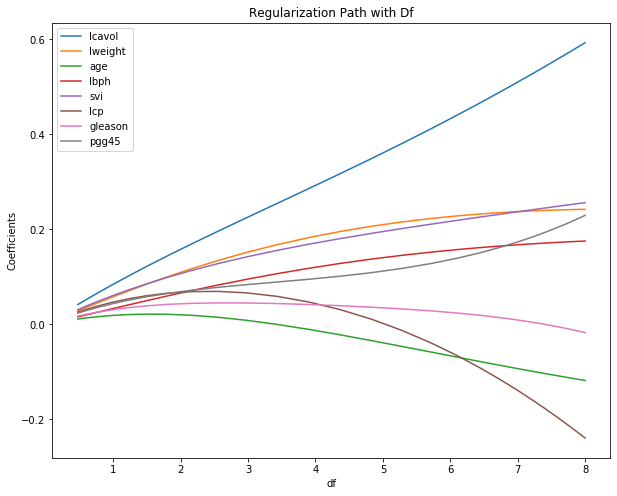

In [41]:
# 自由度 vs 系数
p = X_train.shape[1]
plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(dfs, Betas[:, i], label=str(prostate_train.columns[i]))
plt.title("Regularization Path with Df")
plt.xlabel("df")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

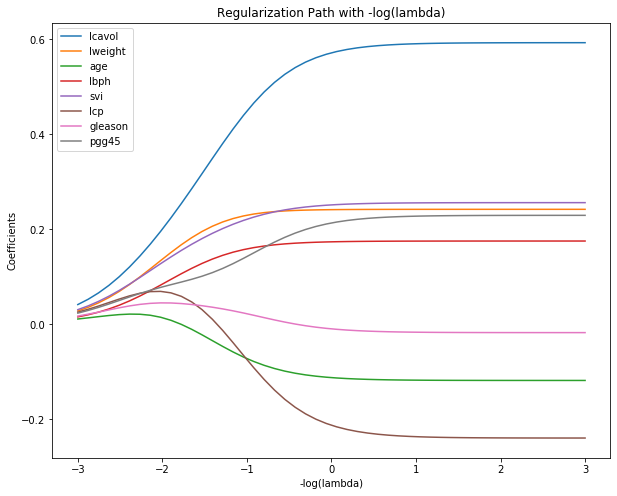

In [40]:
# 正则化参数的对数的负数 vs 系数
plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(-np.log10(lambs), Betas[:, i], label=str(prostate_train.columns[i]))

plt.title("Regularization Path with -log(lambda)")
plt.xlabel("-log(lambda)")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

### SVD分解

In [34]:
U, s, Vh = np.linalg.svd(X_train, full_matrices=False)
V = Vh.T

In [35]:
z1 = X_train @ V[:, 0]
z2 = X_train @ V[:, 1]

In [45]:
top2_components = np.c_[z1, z2]

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_two = pca.fit_transform(X_train)

In [52]:
np.allclose(top2_components[:, 0], X_train_two[:, 0])

True

In [53]:
np.allclose(top2_components[:, 1], -X_train_two[:, 1])

True

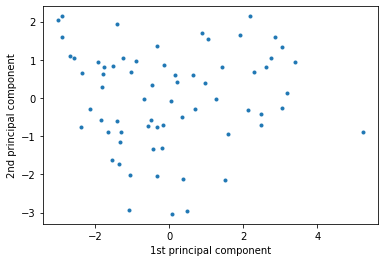

In [56]:
plt.plot(z1, z2, ".")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()